In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from random import randint,choice



In [2]:
class Chromosome:
    def __init__(self,nodes,network):
        self.__nodes=nodes
        self.__network=network
        self.__fitness=0.0
    

    

In [3]:

# read the network details
def readNet(fileName):
    """
    Takes from the file the adjacent matrix(net['mat']) and determines the number of nodes (net['noNodes']) 
    ,the degree of each node('how many neighbours it has') in net['degrees']
    """
    f = open(fileName, "r")
    net = {}
    n = int(f.readline())
    net['noNodes'] = n
    mat = []
    for i in range(n):
        mat.append([])
        line = f.readline()
        elems = line.split(" ")
        for j in range(n):
            mat[-1].append(int(elems[j]))
    net["mat"] = mat 
    degrees = []
    noEdges = 0
    for i in range(n):
        d = 0
        for j in range(n):
            if (mat[i][j] == 1):
                d += 1
            if (j > i):
                noEdges += mat[i][j]
        degrees.append(d)
    net["noEdges"] = noEdges
    net["degrees"] = degrees
    f.close()
    print(net["noEdges"])
    print('\n')
    print(net["degrees"])
    print(net["mat"])
    return net


In [4]:

def plot_matrix(adjacent_matrix):
    """
    plots the matrix without any colors , just to get the general idea of how an example of how a graph with that
    adjacent matrix could look
    """
    warnings.simplefilter('ignore')

    A=np.matrix(adjacent_matrix)
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)  # compute graph layout
    plt.figure(figsize=(4, 4))  # image is 8 x 8 inches 
    nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.show(G)
    
# plot_matrix(network["mat"])


In [37]:
def plot_communities(adjacent_matrix,communities):
    """
    plots an example of an graph with the respective colors of the nodes based on the communities
    """
    A=np.matrix(adjacent_matrix)
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)  # compute graph layout
    plt.figure(figsize=(7, 7))  # image is 8 x 8 inches 
    nx.draw_networkx_nodes(G, pos, node_size = 100, cmap = plt.cm.RdYlBu, node_color = communities)
    nx.draw_networkx_edges(G, pos, alpha = 0.3)
    plt.show(G)

# communities = [1,-1,1,-1,1, 1]
# plot_communities(network["mat"],communities)

In [53]:
def readGml(fileName):
    G = nx.read_gml(fileName, 'id')
    network={}
    matrix = [[0 for x in range(len(G))] for y in range(len(G))]
    network['noNodes'] = len(G)
    network['noEdges'] = G.size()
    for e in G.edges:
#         matrix[e[0]][e[1]] = matrix[e[1]][e[0]] = 1
#         Pentru karate Use this:
        matrix[e[0]-1][e[1]-1] = matrix[e[1]-1][e[0]-1] = 1
    degrees = []
    for nodes in G.nodes:
        degrees.append(G.degree(nodes))
    network['mat'] = matrix
    network['degrees'] = degrees
    return network

def loadNetwork():
#     return readGml("../input/real-2/real/dolphins/dolphins.gml")
#     return readGml("../input/fotball-spectral/football/football.gml")
    return readGml("../input/real-2/real/karate/karate.gml")
#     return readGml("../input/real-2/real/krebs/krebs.gml")
    #return readNet("net.in")
    #return readNet("net2.in")


SyntaxError: invalid syntax (<ipython-input-53-a0dccbfc1e95>, line 9)

In [49]:
class Node:
    def __init__(self, id):
        self.__id = id
        self.__eigenvector = []

    def get_id(self):
        return self.__id

    def get_eigenvectors(self):
        return self.__eigenvector

    def add_eigenvector(self, eigenvector):
        self.__eigenvector.append(eigenvector)

    def determine_community(self):
        """
        Based on how many many values there are negative and positive it calculates a code
        returns:
        code: a int
        """
        code=0
        pt=0
        for v in self.__eigenvector:
            if v <= 0:
                code-=pt
            if v > 0:
                code+=pt
            pt+=1
           
        return code


In [50]:
class Repo:
    def __init__(self, Nodes):
        self.__nodes = Nodes

    def get_by_id(self, id):
        for node in self.__nodes:
            if node.get_id() == id:
                return node


In [51]:
import os

class Service:
    def __init__(self):
        self.__repo = []

    def calculate_Degree_matrix(self, network):
        """
        calculates the Degree matrix
        """
        D = [[0 for _ in range(0, network["noNodes"])] for x in range(0, network["noNodes"])]
        for _ in range(0, network["noNodes"]):
            for v in range(0, network["noNodes"]):
                if _ == v:
                    D[_][v] = network["degrees"][_]
                else:
                    D[_][v] = 0
        return D

    def calculate_Laplacian_matrix(self, network):
        """
        calculates the Laplacian matrix
        """
        D = self.calculate_Degree_matrix(network)
        A = network["mat"]
        B = [[0 for _ in range(0, network["noNodes"])] for __ in range(0, network["noNodes"])]
        for p in range(0, network["noNodes"]):
            for v in range(0, network["noNodes"]):
                B[p][v] = D[p][v] - A[p][v]
        return B

    def eign_eigv(self, L):
        """
        L: Laplacian matrix
        returns:
        eign: a list made out of tuples : (eigenvalue,pos)
        """
        eign, eigv = np.linalg.eig(L)
        eign_arranged = []
        pos = 0
        for _ in eign:
            eign_arranged.append((_, pos))
            pos += 1
        return eign_arranged, eigv

    def calculate_k(self, eign):
        """
        Determine k , the number of communities 
        returns k:int
        """
        k = -999
        h1 = eign[0]
        for h2 in eign[1:]:
            delta = abs(h2[0] - h1[0])
            if k < delta:
                k = delta
            h1 = h2
        return k

    def node_aigen(self, k, eign, eigv, network):
        """
        Given each node an array of k values which are its eigenvectors 
        
        """
        for _ in range(1,network["noNodes"]-1):
            self.__repo.append(Node(_))

        for node in self.__repo:
            for _ in range(0, k - 1):
                node.add_eigenvector(eigv[node.get_id()][_+1])
#                 eign[_ + 1][1]


    def breaking(self, k, eign, eigv, network):
        """
        Calculates for each node a community it think it belongs to
        """
        self.node_aigen(k, eign, eigv, network)

        communities = [0 for _ in range(0, network["noNodes"])]

        for node in self.__repo:
            code = node.determine_community()
            communities[node.get_id()] = code%k
            
        return communities

    def modularity(self, communities, param):
        """
        Calculates the fitness 
        """
        noNodes = param['noNodes']
        mat = param['mat']
        degrees = param['degrees']
        noEdges = param['noEdges']
        M = 2 * noEdges
        Q = 0.0
        for i in range(0, noNodes):
            for j in range(0, noNodes):
                if (communities[i] == communities[j]):
                    #                 set_trace()
                    Q += (mat[i][j] - degrees[i] * degrees[j] / M)
        return Q * 1 / M


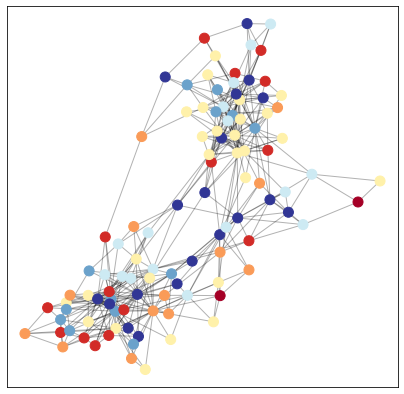

105
[0, 5, 3, 3, 11, 5, 7, 7, 9, 7, 5, 11, 9, 11, 9, 3, 5, 11, 5, 5, 5, 11, 3, 1, 7, 3, 7, 1, 5, 11, 5, 1, 1, 1, 3, 9, 1, 1, 3, 9, 1, 5, 5, 9, 3, 7, 1, 11, 3, 11, 11, 1, 3, 7, 5, 9, 9, 7, 11, 11, 1, 1, 7, 7, 11, 11, 9, 7, 7, 7, 1, 5, 5, 7, 9, 11, 5, 11, 5, 7, 5, 5, 5, 5, 5, 3, 11, 9, 3, 11, 5, 9, 5, 5, 9, 11, 1, 1, 5, 11, 7, 5, 3, 5, 0]
0.005643224788025574 

0.023724682616810832 

0.0056252281713895244 

3  is the best
How many communities
7


In [52]:
def run():
    """
    We determine the best 3 Chromosomes by seeing the fitness of a chromosome with k-1 communities , k and k+1 communities
    """
    network = loadNetwork()
    service = Service()
    L = service.calculate_Laplacian_matrix(network)
    eign, eigv = service.eign_eigv(L)
    k = service.calculate_k(eign)
    
    best_community=[]
    maxi=0
    communities = service.breaking(int(k)+1, eign, eigv, network)
    Q1 = service.modularity(communities, network)

    communities_2 = service.breaking(int(k), eign, eigv, network)
    Q2 = service.modularity(communities_2, network)

    communities_3 = service.breaking(int(k)-1, eign, eigv, network)
    Q3 = service.modularity(communities_3, network)
    
    all_communities=[communities,communities_2,communities_3]
    if Q1<Q2:
        if Q1<=Q3:
            maxi=1
        else:
            maxi=3
    else:
        if Q2<=Q3:
            maxi=2
        else:
            maxi=3
    best_community=all_communities[maxi-1]
    best_community=communities_2
    plot_communities(network["mat"],best_community)
    print(network['noNodes'])
    print(best_community)
    print(Q1,'\n')
    print(Q2,'\n')
    print(Q3,'\n')
    print(maxi," is the best")
    print('How many communities')
    print(len(set(best_community)))
    
run()